# NLP -Beginner 任务1 基于机器学习的文本分类
实现基于logistic/softmax regression的文本分类
1. 参考
   1. [文本分类](文本分类.md)
   2. 《[神经网络与深度学习](https://nndl.github.io/)》 第2/3章
2. 数据集：[Classify the sentiment of sentences from the Rotten Tomatoes dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
3. 实现要求：NumPy
4. 需要了解的知识点：

   1. 文本特征表示：Bag-of-Word，N-gram
   2. 分类器：logistic/softmax  regression，损失函数、（随机）梯度下降、特征选择
   3. 数据集：训练集/验证集/测试集的划分
5. 实验：
   1. 分析不同的特征、损失函数、学习率对最终分类性能的影响
   2. shuffle 、batch、mini-batch 
6. 时间：两周

### 初始化 
导入相应数据，模块包

Dataset类

In [85]:
import numpy as np
import csv
import random
import pandas as pd
import math
import matplotlib.pyplot as plt


class Dataset():
    def __init__(self, filepath = 'train.tsv', max_item = 1000):
        self.file = filepath
        self.max_item = max_item # 提取前max_item个数据，否则数据量太大 BoWs就有大约150000*16000的矩阵，会溢出
        self.data = None
        
    def __call__(self):
        with open(self.file) as f:
            tsvreader = csv.reader(f, delimiter='\t')
            temp = list(tsvreader)
        self.data = temp[1:]  # 忽略了表头
        self.data = np.array(self.data)[:, 2:]  # 忽略序号，句子号等其他信息
        if self.max_item > self.data.shape[0]:
            print(f'too large item_number! it should be less that {self.data.shape[0]}')
        self.data = self.data[:self.max_item, :]
        return self.data




### DataLoader类
目标：实现DataLoader类，将数据集根据Bag of Words 模型或者 N-gram 模型， 转化为特征向量和标签的形式,以X和y返回

In [86]:
class DataLoader:
    def __init__(self, raw_data, method='BoWs', N_features=3):
        self.raw_data = raw_data
        self.method = method
        self.words_dict = dict()
        self.len = 0
        self.X = None                   # 这是特征矩阵
        self.y = self.raw_data[:, -1]    # 这是标签
        self.N = raw_data.shape[0]    # 数据集的sentence条目
        self.N_features = N_features

    def __call__(self):
        if self.method == 'BoWs':
            self.get_words_B()
            self.BoWs()
        elif self.method == "N_grams":
            if self.N_features <= 1:
                raise Exception('The num of feautures should >= 2')
            self.get_words_N()
            self.N_grams()
        else:
            raise Exception('Wrong method, please use BoWs or N_grams')
        return self.X, self.y

    def get_words_B(self):
        '''
        统计所有出现的词数量,构建词典
        '''
        for item in self.raw_data:
            s = item[0]
            s = s.upper()   # 大小写统一是合理并且必要的
            s = s.split()
            for word in s:
                if word not in self.words_dict:
                    # 漂亮的一步（参考）：单词在词典中的值与自然数集对应，从而变为其在特征矩阵中的下标
                    self.words_dict[word] = len(self.words_dict)
        self.len = len(self.words_dict)
        self.X = np.zeros((self.N, self.len))    # 初始化特征矩阵

    def BoWs(self):
        for i in range(self.N):
            s = self.raw_data[i][0]
            s = s.upper()
            s = s.split()
            for word in s:
                self.X[i][self.words_dict[word]] += 1

    def get_words_N(self):
        '''
        统计所有出现的N元特征数量，构建词典
        '''
        for n in range(1,self.N_features + 1):
            for item in self.raw_data:
                s = item[0]
                s = s.upper()
                s = s.split()
                for i in range(len(s) - n + 1):
                    feature = s[i:i+n]
                    feature = '_'.join(feature)
                    if feature not in self.words_dict:
                        self.words_dict[feature] = len(self.words_dict)
        self.len = len(self.words_dict)
        # print("debug: " ,self.len)
        self.X = np.zeros((self.N,self.len))

    def N_grams(self):
        for i in range(self.N):
            s = self.raw_data[i][0]
            s = s.upper()
            s = s.split()
            for n in range(1,self.N_features + 1):
                for j in range(len(s) - n +1):
                    feature = s[j:j+n]
                    feature = '_'.join(feature)
                    self.X[i][self.words_dict[feature]] += 1
            


# 测试一下
# dataloader = DataLoader(raw_data, method='N_grams')
# X, y = dataloader()
# print(X.shape)
# print(y.shape)


### 训练集，验证集的分割

In [87]:
from random import shuffle
random.seed(521)


def train_valid_split(X, y, train_percent=0.8):
    '''
    输入处理好的数据，随机打乱，返回 X_train, X_valid, y_train, y_valid
    '''
    n = len(X)
    indices = list(range(n))
    random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    train_num = int(n*train_percent)
    X_train = X[:train_num, :]
    X_valid = X[train_num:]
    y_train = y[:train_num]
    y_valid = y[train_num:]
    return X_train, X_valid, y_train, y_valid


# 测试一下
# X_train, X_valid, y_train, y_valid = train_valid_split(X, y)

# print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


### Softmax 函数的定义

使用了减去$x_{max}$的方法避免溢出
N个（行）向量成批进行处理

In [88]:
def softmax(X):
    """
    输入：
        - X：shape=[N, C]，N为向量数量，C为向量维度

    成批进行softmax运算

    使用技巧防止溢出
    """
    x_max = np.max(X, axis=1, keepdims=True)
    exp_x = np.exp(X - x_max)
    result = exp_x/np.sum(exp_x, axis=1, keepdims=True)
    return result


# 测试
# Xt = np.array([[1, 2, 3], [4, 5, 6]])
# print(softmax(Xt))


### Softmax回归模型算子
线性函数与softmax函数的结合
同样，将N个样本归为一组，成批进行预测
#### forward函数
$$
\hat{\mathbf Y} = \mathrm{softmax}(\boldsymbol{X} \boldsymbol{W} + \mathbf b)
$$
其中$\boldsymbol{X}\in \mathbb{R}^{N\times D}$为$N$个样本的特征矩阵，$\boldsymbol{W}=[\mathbf w_1,……,\mathbf w_C]$为$C$个类的权重向量组成的矩阵，$\hat{\mathbf Y}\in \mathbb{R}^{C}$为所有类别的预测条件概率组成的矩阵。

input_dim, output_dim 分别对应的输入向量x的维度，以及预测分类的类别维度。

#### backward函数
计算风险函数$\cal R(\mathbf W,\mathbf b)$关于参数$\mathbf W$和$\mathbf b$的偏导数。在Softmax回归中，计算方法为：

$$
\frac{\partial \cal R(\mathbf W,\mathbf b)}{\partial \mathbf W} = -\frac{1}{N}\sum_{n=1}^N \mathbf x^{(n)}(y^{(n)}- \hat{ y}^{(n)})^T = -\frac{1}{N} \mathbf X^ \mathrm{ T } (\mathbf y- \hat{\mathbf y}),（3.17）
$$

$$
\frac{\partial \cal R(\mathbf W,\mathbf b)}{\partial \mathbf b} = -\frac{1}{N}\sum_{n=1}^N (y^{(n)}- \hat{y}^{(n)})^T = -\frac{1}{N} \mathbf 1 (\mathbf y- \hat{\mathbf y}).（3.18）
$$

其中$\mathbf X\in \mathbb{R}^{N\times D}$为$N$个样本组成的矩阵，$\mathbf y\in \mathbb{R}^{N}$为$N$个样本标签组成的向量，$\hat{\mathbf y}\in \mathbb{R}^{N}$为$N$个样本的预测标签组成的向量，$\mathbf{1}$为$N$维的全1向量。

将上述计算方法定义在模型的`backward`函数

#### 对model类的理解

不应让model本身存储输入的训练数据，model本身应该只是储存参数的，在何时何地，调用model，输入数据，输出预测结果，这才是model需要做的事情。

训练过程，就是不断更新model中参数的过程

In [89]:
class model_SR():
    def __init__(self, input_dim, output_dim):
        self.params = {}
        self.params['W'] = np.zeros(shape=[input_dim, output_dim])
        self.params['b'] = np.zeros(shape=[output_dim])
        self.grads = {}
        self.grads['W'] = None
        self.grads['b'] = None
        self.X = None
        self.output = None
        self.output_dim = output_dim

    def __call__(self, input):
        return self.forward(input)

    def forward(self, input):
        """
        输入：
            - inputs: shape=[N,D], N是样本数量，D是特征维度
        输出：
            - outputs：预测值，shape=[N,C]，C是类别数

        此处仅计算，最终的预测分类以及评估放在accuracy函数中
        """
        self.X = input
        score = np.matmul(self.X, self.params['W']) + self.params['b']
        self.output = softmax(score)
        return self.output

    def backward(self, labels):
        """
        输入：
            - labels：真实标签，shape=[N, 1]，其中N为样本数量

        计算交叉熵损失函数对模型各参数的偏导数，用于后续optimizer类更新参数

        偏导数此处利用数学知识人为计算，还需要仔细思考为什么
        """
        N = labels.shape[0]
        labels = np.array(labels,dtype = 'int32')
        labels = np.eye(self.output_dim)[labels]
        self.grads['W'] = -1 / N * np.matmul(self.X.T, (labels-self.output))
        self.grads['b'] = -1 / N * \
            np.matmul(np.ones(shape=[N]), (labels-self.output))


# 测试
# a = np.array([[1, 2, 4, 6], [4, 9, 5, 6]])
# test_model = model_SR(input_dim=4, output_dim=3)
# test_result = test_model(a)
# test_labels = np.array([[2], [0]])
# test_model.backward(test_labels)
# print(test_result)
# print(test_model.grads)


### 损失函数
使用交叉熵损失函数

一般来说，其也应该被包含在模型内，在模型调用backward方法时，自动计算损失函数对不同参数的偏导数

但是本案例模型简单，即用数学方法直接计算了偏导数，损失函数也只是单纯进行计算记录，并不与模型(model)产生关联

In [90]:
class MultiCrossEntropyLoss():
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        """
        输入：
            - predicts：预测值，shape=[N, D]，N为样本数量, D 为 类别数量 
            - labels：真实标签，shape=[N, 1]
        输出：
            - 损失值：shape=[1]
        """
        # print("debug: predicts.shape:", predicts.shape)
        self.predicts = predicts
        self.labels = labels
        self.num = self.predicts.shape[0]
        loss = 0
        for i in range(0, self.num):
            index = int(self.labels[i].item())
            # print("debug here: index = ", index)
            # print("debug here: self.predicts[i] = ",self.predicts[i],self.predicts[i].shape)
            # print("debug:",type(i),type(index))
            loss -= np.log(np.squeeze(self.predicts[i])[index])
        return loss / self.num


### 优化器 Optimizer

In [91]:
class BGD_optimizer():
    def __init__(self, lr, model):
        self.lr = lr
        self.model = model

    def step(self):
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - \
                    self.lr * self.model.grads[key]


### 评价与评价指标 metric

使用accuracy, 在此函数中，输入每批次N个向量的output矩阵和label标签，将output矩阵转化为预测类别的一维向量，并计算accuracy，作为评价指标

In [92]:
def accuracy(output, labels):
    '''
    输入：
        - output [N,C] , C 为可能的类别数量
        - labels [N,1] 
    '''
    preds = np.argmax(output, axis=1)
    preds = np.squeeze(preds)
    labels = np.squeeze(labels)
    preds = np.array(preds,dtype = 'int32')
    labels = np.array(labels, dtype = 'int32')
    return np.mean(np.equal(preds, labels))


# 测试
output = np.array([[0.2, 0.2, 0.6], [0.3, 0.6, 0.1]])
# labels = np.array([2,2])    两种输入都可以接受,内部使用了squeeze
labels = np.array([[2], [2]],dtype = "int64")
print(accuracy(output, labels))


0.5


### Runner 类 的封装
实现Runner类（针对整批量梯度下降法）

Runner类应将各种操作封装好，包括train, evaluate, pred等等，并且在训练过程中适当输出

Runner类应该具有通用性，在实例化时指定需要的model，optimizer，metric，loss_fn这四个参数

对于不同的模型，优化器，只需要在实例化时指定不同的参数即可

实例化后，在train等方法中，再传入训练数据和标签


In [93]:
class Runner():
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        # 记录训练过程中的评价指标变化情况
        self.train_scores = []
        self.valid_scores = []
        # 记录训练过程中的损失函数变化情况
        self.train_loss = []
        self.valid_loss = []
        self.best_score = 0

    def train(self, X_train, y_train, X_valid, y_valid, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        # 传入训练记录的打印频率，如果没有传入值则默认为100
        log_epochs = kwargs.get("log_epochs", 100)
        # 传入模型保存路径，如果没有传入值则默认为"best_model.ppy"
        save_path = kwargs.get("save_path", "best_model.npy")
        for epoch in range(1,num_epochs+1):
            # 前向计算
            valid_output = self.model(X_valid)
            train_output = self.model(X_train) # 前两个顺序还不能乱，写的有点一般，否则会影响到模型中的数据，影响更新参数
            train_loss = self.loss_fn(train_output, y_train)
            valid_loss = self.loss_fn(valid_output, y_valid)
            train_score = self.metric(train_output, y_train)
            valid_score = self.metric(valid_output, y_valid)
            self.train_loss.append(train_loss)
            self.valid_loss.append(valid_loss)
            self.train_scores.append(train_score)
            self.valid_scores.append(valid_score)

            # 反向传播
            self.model.backward(y_train)

            # 更新参数
            self.optimizer.step()

            # 打印输出
            if valid_score > self.best_score:
                print(
                    f"best accuracy performence has been updated: {self.best_score:.5f} --> {valid_score:.5f}")
                self.best_score = valid_score
            if epoch % log_epochs == 0 or epoch == num_epochs:
                print(
                    f"[Train] epoch: {epoch}, loss: {train_loss}, score: {train_score}")
                print(
                    f"[Valid] epoch: {epoch}, loss: {valid_loss}, score: {valid_score}")

    def predict(self, input):
        return self.model(input)
    
    def save_model(self, save_path):
        np.save(save_path, self.model.params)
        
    def load_model(self, load_path):
        return np.load(load_path, allow_pickle= True).item()

### 绘图可视化函数

In [94]:
def plot(runner,fig_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]
    # 绘制训练损失变化曲线
    plt.plot(epochs, runner.train_loss, color='#e4007f', label="Train loss")
    # 绘制评价损失变化曲线
    plt.plot(epochs, runner.valid_loss, color='#f19ec2', linestyle='--', label="valid loss")
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.subplot(1,2,2)
    # 绘制训练准确率变化曲线
    plt.plot(epochs, runner.train_scores, color='#e4007f', label="Train accuracy")
    # 绘制评价准确率变化曲线
    plt.plot(epochs, runner.valid_scores, color='#f19ec2', linestyle='--', label="valid accuracy")
    # 绘制坐标轴和图例
    plt.ylabel("score", fontsize='large')
    plt.xlabel("epoch", fontsize='large')
    plt.legend(loc='lower right', fontsize='x-large')
    plt.tight_layout()
    plt.savefig(fig_name)
    plt.show()

### 模型训练

X_train.shape = (800, 1568)
X_valid.shape = (200, 1568)
Start training
best accuracy performence has been updated: 0.00000 --> 0.03500
best accuracy performence has been updated: 0.03500 --> 0.66000
best accuracy performence has been updated: 0.66000 --> 0.66500
[Train] epoch: 100, loss: 0.884424026508928, score: 0.69625
[Valid] epoch: 100, loss: 1.000713199487505, score: 0.665
best accuracy performence has been updated: 0.66500 --> 0.67000
best accuracy performence has been updated: 0.67000 --> 0.67500
best accuracy performence has been updated: 0.67500 --> 0.68000
best accuracy performence has been updated: 0.68000 --> 0.68500
[Train] epoch: 200, loss: 0.7946312268769213, score: 0.71875
[Valid] epoch: 200, loss: 0.9555935143398772, score: 0.68
[Train] epoch: 300, loss: 0.7450115772388375, score: 0.7375
[Valid] epoch: 300, loss: 0.9435280037643254, score: 0.685
best accuracy performence has been updated: 0.68500 --> 0.69000
best accuracy performence has been updated: 0.69000 --> 0.695

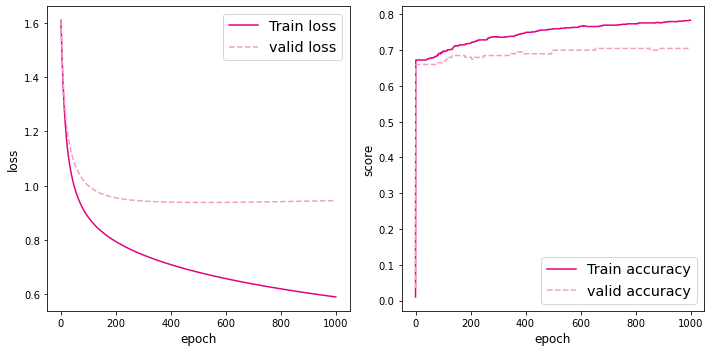

In [95]:
# dataset
dataset = Dataset('train.tsv',max_item=1000)
raw_data = dataset()

# dataloader
dataloader = DataLoader(raw_data, method='N_grams')
X, y = dataloader()

# 随机打乱顺序，划分训练集和验证集
X_train, X_valid, y_train, y_valid = train_valid_split(X, y,train_percent= 0.8)
print(f'X_train.shape = {X_train.shape}\nX_valid.shape = {X_valid.shape}')

# 特征维度
input_dim = X_train.shape[1]
# 类别数
output_dim = 5
# 学习率
lr = 0.1

# 实例化模型
model = model_SR(input_dim=input_dim, output_dim=output_dim)
# 指定优化器
optimizer = BGD_optimizer(lr, model)
# 指定损失函数
loss_fn = MultiCrossEntropyLoss()
# 指定评价方式
metric = accuracy
# 实例化Runner类
runner = Runner(model, optimizer, metric, loss_fn)

# 模型训练
print('Start training')
runner.train(X_train, y_train, X_valid, y_valid, num_epochs=1000 ,log_eopchs=50,  save_path="best_model.npy")

# 可视化
plot(runner,'graph.pdf')